#Anomaly Detection


#Imports

###imports for visualising the data

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

###imports for work on data 

In [ ]:
from sklearn.datasets import make_classification, make_blobs, make_moons
from sklearn.svm import OneClassSVM

import numpy as np

#Setting up datasets


##**generate_points**
function to generate a synthetic dataset to test algorithmic points on returns array's of all points (excluding outliers too close to cluster centres) and a list of all remaining outliers in the data

In [ ]:
def generate_points(i):
  n_samples = 2000

  # modify these settings to obtain different combinations of high density areas (clusters) and outliers
  outliers_fraction = i[0]    ## values to use: 0.01, 0.05, 0.1
  n_outliers = int(outliers_fraction * n_samples)
  n_inliers = n_samples - n_outliers
  num_clusters = i[1]   ## values to use: 5, 10
  stdev = 1
  n_features = 2

  print("total samples: {s} outliers: {o}%, outliers expected:{ot}, inliers:{i}".format(s=n_samples, o=outliers_fraction, ot=n_outliers, i=n_inliers))
  print("blobs: centers: {c}, samples = {n}, std dev: {std}".format(c=num_clusters, n=n_inliers, std=stdev))
  
  samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

  print("clustered samples: {s}".format(s=len(samples)))

  ## range of samples points -- used to determine the boundaries for outliers generation
  boost = 1.1   ## extends the range covered by the clusters
  xmin = min(samples[:,0]) 
  xmax = max(samples[:,0]) 
  ymin = min(samples[:,1]) 
  ymax = max(samples[:,1]) 
  print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
  print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

  low = min(xmin, ymin) * boost
  high = max(xmax, ymax) * boost
  print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

  # Add n_outlier outliers, n_features each 
  rng = np.random.RandomState(42)
  outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
  print("number of outliers produced: {o}".format(o=len(outliers)))

  ## some of the outliers are within clusters. 
  ## we use the distance from centers to remove some of the outliers, as those will never be detected
  distances = dict()
  out = dict()
  i=0
  for o in outliers:
      mindist = 1000000
      for c in centers:
          dist = np.linalg.norm(o-c)  ## euclidean distance
          if dist < mindist:
              mindist = dist
      out[i] = o
      distances[i]= mindist
      i = i + 1

  distarray = np.asarray(list(distances.values()))
  meandist  = np.mean(distarray)
  vardist   = np.std(distarray)

  print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

  ## remove points that are too close to the centers

  alpha = 1.2 ## larger than1 removes points that are more distant from centroids

  removed = 0
  for i in range(len(outliers)):
      if distances[i] < meandist-vardist * alpha:
          print("removing {d:.2f}".format(d=distances[i]))
          out.pop(i)
          removed = removed + 1

  finalOutliers = np.asarray(list(out.values()))
  print("removed {r} outliers. {n} remaining outliers ".format(r=removed, n=len(finalOutliers)))
  full_set = np.concatenate([samples, finalOutliers], axis=0)
  return full_set, finalOutliers

###creating datasets for each possible set of options

In [ ]:
options = [[0.01, 5],[0.01, 10],[0.05, 5],[0.05, 10],[0.1, 5],[0.1, 10]]
sample_lists = []
outlier_lists = []
for i in options:
  full_data, outliers = generate_points(i)
  sample_lists.append(full_data)
  outlier_lists.append(outliers)

total samples: 2000 outliers: 0.01%, outliers expected:20, inliers:1980
blobs: centers: 5, samples = 1980, std dev: 1
clustered samples: 1980
xmin: -4.64, xmax: 12.15
ymin: -5.72, ymax: 10.20
low, high for outliers: -6.30, 13.37
number of outliers produced: 20
outliers distances from centres: mean 4.73, var 2.60
removing 0.83
removing 1.32
removing 1.47
removing 1.23
removed 4 outliers. 16 remaining outliers 
total samples: 2000 outliers: 0.01%, outliers expected:20, inliers:1980
blobs: centers: 10, samples = 1980, std dev: 1
clustered samples: 1980
xmin: -12.60, xmax: 11.89
ymin: -10.52, ymax: 10.77
low, high for outliers: -13.86, 13.08
number of outliers produced: 20
outliers distances from centres: mean 5.09, var 3.01
removing 0.77
removing 0.63
removed 2 outliers. 18 remaining outliers 
total samples: 2000 outliers: 0.05%, outliers expected:100, inliers:1900
blobs: centers: 5, samples = 1900, std dev: 1
clustered samples: 1900
xmin: -4.64, xmax: 13.07
ymin: -5.72, ymax: 10.20
low, 

#KNN Algorithm Approach


##**sample_finder** 
Finds the k closest samples from each sample

In [ ]:
def sample_finder(samples_dict):
  for x in range(0, len(samples_dict)):
    k_order = []
    for i in range(0, len(samples_dict)):
      if i != x: 
        k_order.append(np.linalg.norm(samples_dict[i]['location'] -
                                          samples_dict[x]['location']))
    k_order.sort()
    # k as defined globably for number of compared elements
    k_order = k_order[:k]
    samples_dict[x].update({'k_nearest_samples':k_order})
  return samples_dict


##**dict_sort**
for custom sort returning k_mean value


In [ ]:
def dict_sort(i):
  return i['k_mean']

##**KNN**
host for KNN algorithm returning a list of dictionary objects expected to be outliers

In [ ]:
def KNN (sample_lists, test_k_mean):
  sample_dicts = []
  for i in range(0, len(sample_lists)):
    samples_dict = []
    for x in range(0, len(sample_lists[i])):
      samples_dict.append({'location': sample_lists[i][x],
                          'original_list_location': x})
    samples_dict = sample_finder(samples_dict)
    to_delete = []
    for x in range(0, len(samples_dict)):
      k_mean = sum(samples_dict[x]['k_nearest_samples']) / k
      if k_mean <= test_k_mean[i]:
        to_delete.append(x)
      samples_dict[x].update({'k_mean': k_mean})
    x = 0 
    for j in to_delete:
      del samples_dict[j-x]
      x+=1
    samples_dict.sort(reverse=True, key=dict_sort)
    sample_dicts.append(samples_dict)
  return sample_dicts
  

###obtaining standard KNN outliers set
takes approximately 3 minutes to run for all option sets (30s each)

In [ ]:
k = 10
k_mean = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
knn_outliers = KNN(sample_lists, k_mean)

###obtaining k_mean adjusted KNN outliers set
takes approximately 3 minutes to run for all option sets (30s each)

In [ ]:
k = 10
k_mean = [1.5, 1.5, 1.4, 1.4, 0.95, 0.95]
k_mean_adjusted_knn_outliers = KNN(sample_lists, k_mean)

###obtaining k value adjusted knn outliers set
takes approximately 3 minutes to run for all option sets (30s each)

In [ ]:
k = 30
k_mean = [2, 2, 1.75, 1.75, 1.5, 1.5]
k_adjusted_knn_outliers = KNN(sample_lists, k_mean)

#OneClassSVM Algorithm Approach

##**SVM**
Host for SVM algorithm returning a list of dictionary objects expected to be outliers

In [ ]:
## https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
## https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html
## above used to help implement scikit's version of the OneClassSVM approach 

def SVM (sample_lists, nu):
  sample_dicts = []
  for i in range(0, len(sample_lists)):
    samples_dict = []
    # nu assumes some knowledge of ratio of outliers to normal points
    clf = OneClassSVM(gamma='scale', nu=nu[i][0]).fit(sample_lists[i])
    out_list = clf.predict(sample_lists[i])
    for x in range(0, len(out_list)):
      if out_list[x] == -1:
        samples_dict.append({'location': sample_lists[i][x],
                          'original_list_location': x})
    sample_dicts.append(samples_dict)
  return sample_dicts

###obtaining standard outliers set

In [ ]:
svm_outliers = SVM(sample_lists, options)

###*note on nu*

As before this classification approach is used 'points too close to the centre' have been removed this will always be a slight overprediction which will inevitably lead to an increase in false positives within the results. Although, this is expected behaviour so can be accounted for when the results are calculated.

Below is a repeat of finding the SVM outliers but adjusting nu to be closer to reality using knowledge of the removed outliers before this stage to compare to see how much this change impacts results

###obtaining nu adjusted outliers set

In [ ]:
nu = []
for i in range(0, len(outlier_lists)):
  ##second value set to 0 as it is not used here
  nu.append([len(outlier_lists[i])/(len(sample_lists[i])+len(outlier_lists[i])), 0])
nu_adjusted_svm_outliers = SVM(sample_lists, nu)

##Code to automate optimising nu values
produces optimal nu values for each different data set to 3 d.p. takes approximately 30mins time to run. Commented out to avoid running at runtime as the resulting values are already used in the function below

In [ ]:
#nu_values =[[0.001,0],[0.001,0],[0.001,0],[0.001,0],[0.001,0],[0.001,0]]
#best_scores = [0,0,0,0,0,0]
#for i in range(1, 1000):
#  nu_manually_adjusted_svm_outliers = SVM(sample_lists, [[i/1000, 0],[i/1000, 0],[i/1000, 0],[i/1000, 0],[i/1000, 0],[i/1000, 0]])
#  for x in range(0, len(nu_manually_adjusted_svm_outliers)):
#    scores, results = score_finder(nu_manually_adjusted_svm_outliers[x], outlier_lists[x])
#    if scores['f1'] >= best_scores[x]:
#      nu_values[x][0] = i/1000
#      best_scores[x] = scores['f1']
#print(nu_values, best_scores)

###**Commentary on this approach to score optomisation**

###obtaining optimal nu outliers set
based on the values gathered by the above code

In [ ]:
nu = [[0.011, 0], [0.014, 0], [0.047, 0], [0.051, 0], [0.101, 0], [0.069, 0]]
nu_recursively_adjusted_svm_outliers = SVM(sample_lists, nu)

#Score Finders

##**results_finder** 
to find number of true positives, false positives and false negatives

In [ ]:
def results_finder(expected_outliers, actual_outliers):
    results = {}
    true_positives=0
    false_positives=0
    for i in expected_outliers:
        found = False
        for x in actual_outliers:
          if (i['location'][0] == x[0]) & (i['location'][1] == x[1]):
            true_positives+=1 
            found = True
            break
        if found == False:
            false_positives+=1
    results['true_positives'] = true_positives
    results['false_positives'] = false_positives
    results['false_negatives'] = len(actual_outliers) - true_positives
    print("True Positives: " + str(results['true_positives']) 
    + " False Positives: " + str(results['false_positives']) 
    + " False Negatives: " + str(results['false_negatives']))
    return (results)

##**score_finder** 
to calculate the prceision, recall and f1 values given the number of true positives, false positives and false negatives

In [ ]:
def score_finder(expected_outliers, actual_outliers):
    results = results_finder(expected_outliers, actual_outliers)
    precision = results['true_positives'] / (results['true_positives'] + results['false_positives'])
    recall = results['true_positives'] / (results['true_positives'] + results['false_negatives'])
    f1 = 2 * ((precision * recall) / (precision + recall))
    print("Recall: " + str(recall) + " Precision: " +
          str(precision) + " F1: " + str(f1))
    return {"recall":recall, "precision":precision, "f1":f1}, results

#Scores

##KNN Scores


###Unadjusted KNN scores
k = 10 <br />
k_mean = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5]

In [ ]:
knn_scores = []
for i in range(0, len(knn_outliers)):
  print("\033[3m\033[1mKNN scores for options outliers_fraction: " + str(options[i][0]) + " and num_clusters: " + str(options[i][1]) + "\033[0m")
  score, results = score_finder(knn_outliers[i], outlier_lists[i])
  knn_scores.append(score['f1'])
  print("\n")
  

KNN scores for options outliers_fraction: 0.01 and num_clusters: 5
True Positives: 14 False Positives: 3 False Negatives: 2
Recall: 0.875 Precision: 0.8235294117647058 F1: 0.8484848484848485


KNN scores for options outliers_fraction: 0.01 and num_clusters: 10
True Positives: 14 False Positives: 5 False Negatives: 4
Recall: 0.7777777777777778 Precision: 0.7368421052631579 F1: 0.7567567567567567


KNN scores for options outliers_fraction: 0.05 and num_clusters: 5
True Positives: 67 False Positives: 2 False Negatives: 24
Recall: 0.7362637362637363 Precision: 0.9710144927536232 F1: 0.8375


KNN scores for options outliers_fraction: 0.05 and num_clusters: 10
True Positives: 70 False Positives: 3 False Negatives: 16
Recall: 0.813953488372093 Precision: 0.958904109589041 F1: 0.880503144654088


KNN scores for options outliers_fraction: 0.1 and num_clusters: 5
True Positives: 95 False Positives: 1 False Negatives: 93
Recall: 0.5053191489361702 Precision: 0.9895833333333334 F1: 0.6690140845070

###KNN k mean adjusted scores
k = 10 <br /> 
k_mean = [1.5, 1.5, 1.4, 1.4, 0.95, 0.95]

In [ ]:
knn_mean_adjusted_scores = []
for i in range(0, len(k_mean_adjusted_knn_outliers)):
  print("\033[3m\033[1mKNN scores for options outliers_fraction: " + str(options[i][0]) + " and num_clusters: " + str(options[i][1]) + "\033[0m")
  score, results = score_finder(k_mean_adjusted_knn_outliers[i], outlier_lists[i])
  knn_mean_adjusted_scores.append(score['f1'])
  print("\n")

KNN scores for options outliers_fraction: 0.01 and num_clusters: 5
True Positives: 14 False Positives: 3 False Negatives: 2
Recall: 0.875 Precision: 0.8235294117647058 F1: 0.8484848484848485


KNN scores for options outliers_fraction: 0.01 and num_clusters: 10
True Positives: 14 False Positives: 5 False Negatives: 4
Recall: 0.7777777777777778 Precision: 0.7368421052631579 F1: 0.7567567567567567


KNN scores for options outliers_fraction: 0.05 and num_clusters: 5
True Positives: 67 False Positives: 5 False Negatives: 24
Recall: 0.7362637362637363 Precision: 0.9305555555555556 F1: 0.8220858895705522


KNN scores for options outliers_fraction: 0.05 and num_clusters: 10
True Positives: 72 False Positives: 6 False Negatives: 14
Recall: 0.8372093023255814 Precision: 0.9230769230769231 F1: 0.878048780487805


KNN scores for options outliers_fraction: 0.1 and num_clusters: 5
True Positives: 141 False Positives: 13 False Negatives: 47
Recall: 0.75 Precision: 0.9155844155844156 F1: 0.82456140350

###KNN k value adjusted scores
k = 30 <br /> 
k_mean = [2, 2, 1.75, 1.75, 1.5, 1.5]

In [ ]:
k_adjusted_knn_scores = []
for i in range(0, len(k_adjusted_knn_outliers)):
  print("\033[3m\033[1mKNN scores for options outliers_fraction: " + str(options[i][0]) + " and num_clusters: " + str(options[i][1]) + "\033[0m")
  score, results = score_finder(k_adjusted_knn_outliers[i], outlier_lists[i])
  k_adjusted_knn_scores.append(score['f1'])
  print("\n")

KNN scores for options outliers_fraction: 0.01 and num_clusters: 5
True Positives: 14 False Positives: 3 False Negatives: 2
Recall: 0.875 Precision: 0.8235294117647058 F1: 0.8484848484848485


KNN scores for options outliers_fraction: 0.01 and num_clusters: 10
True Positives: 14 False Positives: 2 False Negatives: 4
Recall: 0.7777777777777778 Precision: 0.875 F1: 0.823529411764706


KNN scores for options outliers_fraction: 0.05 and num_clusters: 5
True Positives: 67 False Positives: 4 False Negatives: 24
Recall: 0.7362637362637363 Precision: 0.9436619718309859 F1: 0.8271604938271604


KNN scores for options outliers_fraction: 0.05 and num_clusters: 10
True Positives: 72 False Positives: 8 False Negatives: 14
Recall: 0.8372093023255814 Precision: 0.9 F1: 0.8674698795180723


KNN scores for options outliers_fraction: 0.1 and num_clusters: 5
True Positives: 137 False Positives: 7 False Negatives: 51
Recall: 0.7287234042553191 Precision: 0.9513888888888888 F1: 0.8253012048192772


KNN sco

###Average scores for each KNN aproach

In [ ]:
print("Approach 1: k = 10 k_mean = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5]\nAverage Score = " + str(sum(knn_scores)/len(knn_scores)) + "\n")
print("Approach 2: k = 10 k_mean = [1.5, 1.5, 1.4, 1.4, 0.95, 0.95]\nAverage Score = " + str(sum(knn_mean_adjusted_scores)/len(knn_mean_adjusted_scores)) + "\n")
print("Approach 3: k = 30 k_mean = [2, 2, 1.75, 1.75, 1.5, 1.5]\nAverage Score = " + str(sum(k_adjusted_knn_scores)/len(k_adjusted_knn_scores)) + "\n")

Approach 1: k = 10 k_mean = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
Average Score = 0.8047119493565115

Approach 2: k = 10 k_mean = [1.5, 1.5, 1.4, 1.4, 0.95, 0.95]
Average Score = 0.8289188496338579

Approach 3: k = 30 k_mean = [2, 2, 1.75, 1.75, 1.5, 1.5]
Average Score = 0.8382839917514099



###Best KNN score for each dataset 

In [ ]:
for i in range(0, len(knn_scores)):
  num = max(knn_scores[i], knn_mean_adjusted_scores[i], k_adjusted_knn_scores[i])
  top_scorers = ""
  if knn_scores[i] == num:
    top_scorers += "knn_scores"
  if knn_mean_adjusted_scores[i] == num:
    if top_scorers != "":
      top_scorers += ", "
    top_scorers += "knn_mean_adjusted_scores"
  if k_adjusted_knn_scores[i] == num:
    if top_scorers != "":
      top_scorers += ", "
    top_scorers += "k_adjusted_knn_scores"
  print("Dataset "+ str(i+1) + ": outliers_fraction = " + str(options[i][0]) + " num_clusters = " + str(options[i][1]),
        "\nHighest Value: " + str(num),
        "\nFrom: " + top_scorers + "\n")

Dataset 1: outliers_fraction = 0.01 num_clusters = 5 
Highest Value: 0.8484848484848485 
From: knn_scores, knn_mean_adjusted_scores, k_adjusted_knn_scores

Dataset 2: outliers_fraction = 0.01 num_clusters = 10 
Highest Value: 0.823529411764706 
From: k_adjusted_knn_scores

Dataset 3: outliers_fraction = 0.05 num_clusters = 5 
Highest Value: 0.8375 
From: knn_scores

Dataset 4: outliers_fraction = 0.05 num_clusters = 10 
Highest Value: 0.880503144654088 
From: knn_scores

Dataset 5: outliers_fraction = 0.1 num_clusters = 5 
Highest Value: 0.8253012048192772 
From: k_adjusted_knn_scores

Dataset 6: outliers_fraction = 0.1 num_clusters = 10 
Highest Value: 0.8435754189944135 
From: knn_mean_adjusted_scores



###Graph visualisation of dataset 5
Showing how the unadjusted KNN approach fails to get similar scores to the other two approaches on dataset 5 visually where outliers are in black and normal data is in green.

For example, the regions highlighted by the black boxes (although others are visible) on the unadjusted graph shows the values this approach is missing. Likely since these outliers are in microclusters meaning that the low k value coupled with the relatively high k_mean value required to be considered an outlier means that these points are missed.

Text(0.51, 0.92, 'KNN comparsions on dataset 5')

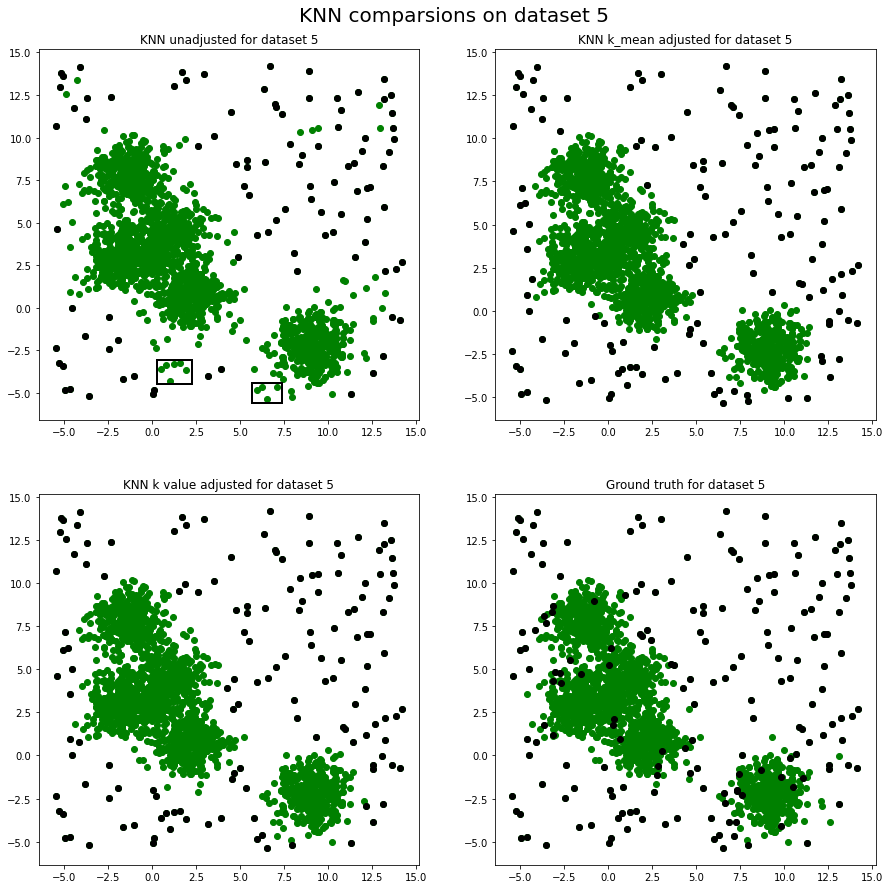

In [ ]:
fig = plt.figure(figsize=(15,15))

ax0 = plt.subplot(2, 2, 1)
ax0.scatter(sample_lists[4][:,0], sample_lists[4][:,1], color='green')
for x in knn_outliers[4]:
  ax0.scatter(x['location'][0], x['location'][1], color='k')
ax0.add_patch(patches.Rectangle((0.3,-4.5), 2, 1.45, linewidth=2, edgecolor='k', facecolor='none'))
ax0.add_patch(patches.Rectangle((5.7,-5.6), 1.7, 1.2, linewidth=2, edgecolor='k', facecolor='none'))
ax0.set_title("KNN unadjusted for dataset 5")

ax1 = plt.subplot(2, 2, 2)
ax1.scatter(sample_lists[4][:,0], sample_lists[4][:,1], color='green')
for x in k_mean_adjusted_knn_outliers[4]:
  ax1.scatter(x['location'][0], x['location'][1], color='k')
ax1.set_title("KNN k_mean adjusted for dataset 5")

ax2 = plt.subplot(2, 2, 3)
ax2.scatter(sample_lists[4][:,0], sample_lists[4][:,1], color='green')
for x in k_adjusted_knn_outliers[4]:
  ax2.scatter(x['location'][0], x['location'][1], color='k')
ax2.set_title("KNN k value adjusted for dataset 5")

ax3 = plt.subplot(2, 2, 4)
ax3.scatter(sample_lists[4][:,0], sample_lists[4][:,1], color='green')
ax3.scatter(outlier_lists[4][:,0], outlier_lists[4][:,1], color='k')
ax3.set_title("Ground truth for dataset 5")

fig.suptitle("KNN comparsions on dataset 5", fontsize=20, x=0.51, y=0.92)

###*Observations about the KNN scores*

Overall these scores are reasonably impressive given the imbalance in the data. All 3 approaches lead to results for all the datasets between 0.75 - 0.9 (excluding one result*) in terms of f1 score. There's no true standout approach here with any adjustments to k and the k_mean threshold doing little to change the results.

Between the standard set and the k_mean adjusted set, mild improvements can be found in datasets 2 and 6 but the main gain is in dataset 5 with a substantial improvement (0.669 to 0.825** 3d.p.). Apart from this though I actually couldn't improve datasets 3 and 4 as the precision fell at such speed when the threshold was reduced that the recall gains weren't enough to make up for it in terms of raw f1 score although I decided to keep it this way to demonstrate how one could improve the recall score as overall these models all lean to be precision score heavy.

Between the standard set and the k value adjusted set once again mild improvements can be found in datasets 2 and 6 but the main gain is in dataset 5 with another substantial improvement (0.669 to 0.825** 3d.p). Once again there's loses here in dataset's 3 and 4 as when precision fell recall once again couldn't rise fast enough to give a greater f1 score with the values I tested. This means overall for the outliers_fraction 0.05 the original dataset is the best still.

On average scores, due to the poor performance the unadjusted KNN approach has on dataset 5 it has the lowest at 0.805 (3d.p.) whilst the adjusted k_value set has the highest at 0.838 (3d.p) which is a relatively small improvement but is enough to say it's better even if this is reliant on dataset 5.

Overall, the unadjusted results serve to be a good representation but the other two more exact approaches show some adjustments could still be made to improve the scores. When comparing this to SVM therefore I will mostly talk about the unadjusted KNN approach in comparison to the SVM approach as this is the easiest to compare with although I will also mention these more optimised approaches in brief. 

<br />*This being the unadjusted KNN approaches result for dataset 5 which is discussed later on in this MD

<br />**Note the score from the k value adjusted set is higher than the k mean adjusted set when not rounded to 3d.p. although this is minor it is worth noting

##SVM Scores

###Unadjusted SVM scores

In [ ]:
svm_scores = []
for i in range(0, len(svm_outliers)):
  print("\033[3m\033[1mSVM scores for options outliers_fraction: " + str(options[i][0]) + " and num_clusters: " + str(options[i][1]) + "\033[0m")
  scores, results = score_finder(svm_outliers[i], outlier_lists[i])
  svm_scores.append(scores['f1'])
  print("\n")

SVM scores for options outliers_fraction: 0.01 and num_clusters: 5
True Positives: 11 False Positives: 14 False Negatives: 5
Recall: 0.6875 Precision: 0.44 F1: 0.5365853658536586


SVM scores for options outliers_fraction: 0.01 and num_clusters: 10
True Positives: 9 False Positives: 13 False Negatives: 9
Recall: 0.5 Precision: 0.4090909090909091 F1: 0.45


SVM scores for options outliers_fraction: 0.05 and num_clusters: 5
True Positives: 68 False Positives: 32 False Negatives: 23
Recall: 0.7472527472527473 Precision: 0.68 F1: 0.7120418848167539


SVM scores for options outliers_fraction: 0.05 and num_clusters: 10
True Positives: 55 False Positives: 43 False Negatives: 31
Recall: 0.6395348837209303 Precision: 0.5612244897959183 F1: 0.5978260869565217


SVM scores for options outliers_fraction: 0.1 and num_clusters: 5
True Positives: 141 False Positives: 59 False Negatives: 47
Recall: 0.75 Precision: 0.705 F1: 0.7268041237113401


SVM scores for options outliers_fraction: 0.1 and num_clu

###SVM nu adjusted scores

In [ ]:
nu_adjusted_svm_scores = []
for i in range(0, len(nu_adjusted_svm_outliers)):
  print("\033[3m\033[1mSVM scores for options outliers_fraction: " + str(options[i][0]) + " and num_clusters: " + str(options[i][1]) + "\033[0m")
  scores, results = score_finder(nu_adjusted_svm_outliers[i], outlier_lists[i])
  nu_adjusted_svm_scores.append(scores['f1'])
  print("\n")

SVM scores for options outliers_fraction: 0.01 and num_clusters: 5
True Positives: 8 False Positives: 16 False Negatives: 8
Recall: 0.5 Precision: 0.3333333333333333 F1: 0.4


SVM scores for options outliers_fraction: 0.01 and num_clusters: 10
True Positives: 7 False Positives: 15 False Negatives: 11
Recall: 0.3888888888888889 Precision: 0.3181818181818182 F1: 0.35000000000000003


SVM scores for options outliers_fraction: 0.05 and num_clusters: 5
True Positives: 63 False Positives: 27 False Negatives: 28
Recall: 0.6923076923076923 Precision: 0.7 F1: 0.6961325966850829


SVM scores for options outliers_fraction: 0.05 and num_clusters: 10
True Positives: 48 False Positives: 31 False Negatives: 38
Recall: 0.5581395348837209 Precision: 0.6075949367088608 F1: 0.5818181818181818


SVM scores for options outliers_fraction: 0.1 and num_clusters: 5
True Positives: 125 False Positives: 47 False Negatives: 63
Recall: 0.6648936170212766 Precision: 0.7267441860465116 F1: 0.6944444444444444


SVM s

###SVM nu recursively adjusted scores

In [ ]:
nu_recursively_adjusted_svm_scores = []
for i in range(0, len(nu_recursively_adjusted_svm_outliers)):
  print("\033[3m\033[1mSVM scores for options outliers_fraction: " + str(options[i][0]) + " and num_clusters: " + str(options[i][1]) + "\033[0m")
  scores, results = score_finder(nu_recursively_adjusted_svm_outliers[i], outlier_lists[i])
  nu_recursively_adjusted_svm_scores.append(scores['f1'])
  print("\n")

SVM scores for options outliers_fraction: 0.01 and num_clusters: 5
True Positives: 11 False Positives: 9 False Negatives: 5
Recall: 0.6875 Precision: 0.55 F1: 0.6111111111111112


SVM scores for options outliers_fraction: 0.01 and num_clusters: 10
True Positives: 11 False Positives: 17 False Negatives: 7
Recall: 0.6111111111111112 Precision: 0.39285714285714285 F1: 0.4782608695652174


SVM scores for options outliers_fraction: 0.05 and num_clusters: 5
True Positives: 68 False Positives: 27 False Negatives: 23
Recall: 0.7472527472527473 Precision: 0.7157894736842105 F1: 0.7311827956989246


SVM scores for options outliers_fraction: 0.05 and num_clusters: 10
True Positives: 58 False Positives: 43 False Negatives: 28
Recall: 0.6744186046511628 Precision: 0.5742574257425742 F1: 0.6203208556149732


SVM scores for options outliers_fraction: 0.1 and num_clusters: 5
True Positives: 143 False Positives: 61 False Negatives: 45
Recall: 0.7606382978723404 Precision: 0.7009803921568627 F1: 0.72959

###Average scores for each SVM approach

In [ ]:
print("Approach 1: Unadjusted SVM\nAverage Score = " + str(sum(svm_scores)/len(svm_scores)) + "\n")
print("Approach 2: nu adjusted SVM\nAverage Score = " + str(sum(nu_adjusted_svm_scores)/len(nu_adjusted_svm_scores)) + "\n")
print("Approach 3: nu recursively adjusted SVM\nAverage Score = " + str(sum(nu_recursively_adjusted_svm_scores)/len(nu_recursively_adjusted_svm_scores)) + "\n")

Approach 1: Unadjusted SVM
Average Score = 0.6050196032749366

Approach 2: nu adjusted SVM
Average Score = 0.5570463773138968

Approach 3: nu recursively adjusted SVM
Average Score = 0.6346152405813877



###Best SVM score for each dataset

In [ ]:
for i in range(0, len(svm_scores)):
  num = max(svm_scores[i], nu_adjusted_svm_scores[i], nu_recursively_adjusted_svm_scores[i])
  top_scorers = ""
  if svm_scores[i] == num:
    top_scorers += "svm_scores"
  if nu_adjusted_svm_scores[i] == num:
    if top_scorers != "":
      top_scorers += ", "
    top_scorers += "nu_adjusted_svm_scores"
  if nu_recursively_adjusted_svm_scores[i] == num:
    if top_scorers != "":
      top_scorers += ", "
    top_scorers += "nu_recursively_adjusted_svm_scores"
  print("Dataset "+ str(i+1) + ": outliers_fraction = " + str(options[i][0]) + " num_clusters = " + str(options[i][1]),
        "\nHighest Value: " + str(num),
        "\nFrom: " + top_scorers + "\n")

Dataset 1: outliers_fraction = 0.01 num_clusters = 5 
Highest Value: 0.6111111111111112 
From: nu_recursively_adjusted_svm_scores

Dataset 2: outliers_fraction = 0.01 num_clusters = 10 
Highest Value: 0.4782608695652174 
From: nu_recursively_adjusted_svm_scores

Dataset 3: outliers_fraction = 0.05 num_clusters = 5 
Highest Value: 0.7311827956989246 
From: nu_recursively_adjusted_svm_scores

Dataset 4: outliers_fraction = 0.05 num_clusters = 10 
Highest Value: 0.6203208556149732 
From: nu_recursively_adjusted_svm_scores

Dataset 5: outliers_fraction = 0.1 num_clusters = 5 
Highest Value: 0.7295918367346939 
From: nu_recursively_adjusted_svm_scores

Dataset 6: outliers_fraction = 0.1 num_clusters = 10 
Highest Value: 0.637223974763407 
From: nu_recursively_adjusted_svm_scores



###Graph visualisation of dataset 2
Showing how the SVM approaches particularly struggles with dataset 2 often missing the outliers on the edge of clusters and instead misidentifying other similar points on the edges which aren't outliers in this case.

In particular, it's interesting to note that the first two approaches produce similar results due to their realistic nu values identifying similar false positives whilst the recursively adjusted nu has little resemblance to these two. 

Text(0.51, 0.92, 'SVM comparsions on dataset 2')

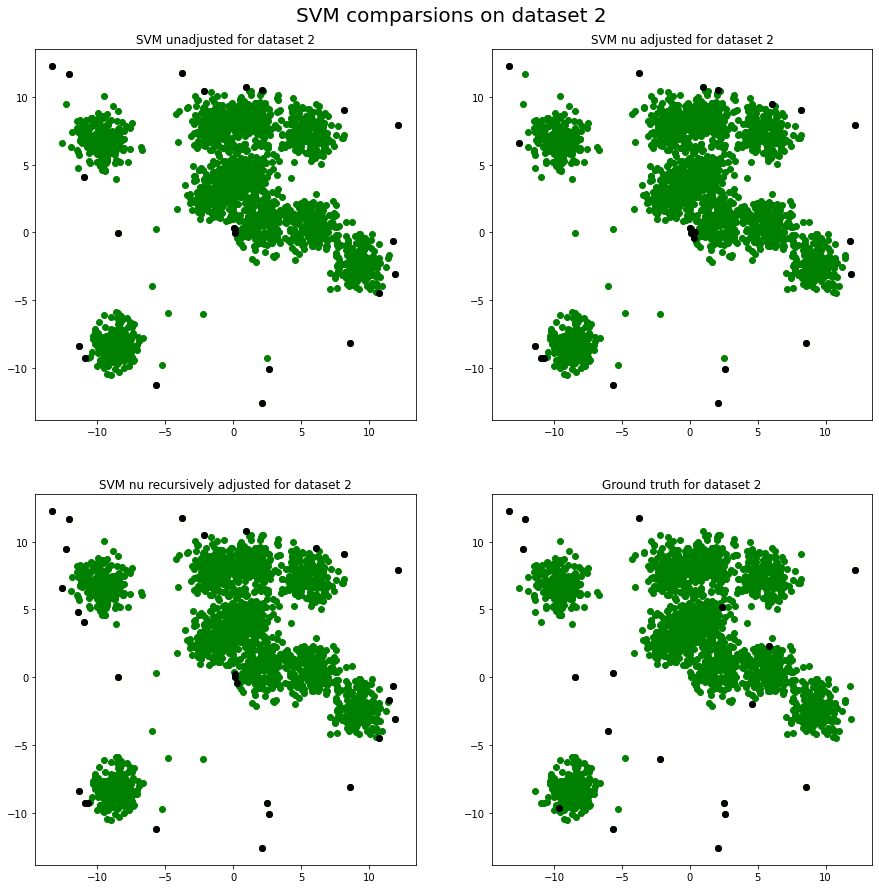

In [ ]:
fig = plt.figure(figsize=(15,15))

ax0 = plt.subplot(2, 2, 1)
ax0.scatter(sample_lists[1][:,0], sample_lists[1][:,1], color='green')
for x in svm_outliers[1]:
  ax0.scatter(x['location'][0], x['location'][1], color='k')
ax0.set_title("SVM unadjusted for dataset 2")

ax1 = plt.subplot(2, 2, 2)
ax1.scatter(sample_lists[1][:,0], sample_lists[1][:,1], color='green')
for x in nu_adjusted_svm_outliers[1]:
  ax1.scatter(x['location'][0], x['location'][1], color='k')
ax1.set_title("SVM nu adjusted for dataset 2")

ax2 = plt.subplot(2, 2, 3)
ax2.scatter(sample_lists[1][:,0], sample_lists[1][:,1], color='green')
for x in nu_recursively_adjusted_svm_outliers[1]:
  ax2.scatter(x['location'][0], x['location'][1], color='k')
ax2.set_title("SVM nu recursively adjusted for dataset 2")

ax3 = plt.subplot(2, 2, 4)
ax3.scatter(sample_lists[1][:,0], sample_lists[1][:,1], color='green')
ax3.scatter(outlier_lists[1][:,0], outlier_lists[1][:,1], color='k')
ax3.set_title("Ground truth for dataset 2")

fig.suptitle("SVM comparsions on dataset 2", fontsize=20, x=0.51, y=0.92)

###*Observations about the SVM scores*

Overall, these scores aren't very impressive by themselves (0.35-0.75 2d.p), very clear improvements are made via adjusting the nu although these will be challenged later. <br />

The real reason these scores have some merit is due to the almost 0s runtime required by the program to come to these results. When put into a 0 runtime context they produce pretty admirable results allowing SVM to quickly identify outlier bases to be manually looked at. <br />

Between the 3 approaches used here, the recursive approach will always have the best results since its pure job is to get the best results (to 3 d.p.) but these results do not apply to any other dataset and mostly are present to prove the absolute limits of the SVM algorithm approach. This is because nu is meant to be representative of the proportion of outliers within the data meaning changing it purely for score optimisation is unlikely to be repeatable results-wise as this is an effectively random chance for finding the best results. <br />

Therefore, between the other two approaches excluding the first two datasets score between 0.582 and 0.723 (3 d.p) were achieved which are quite reasonable considering the effective 0 run time. The unadjusted SVM wins out in every matchup here except on dataset 6 where the result is within a small boundary so can be considered within a margin of error. Meaning, I would recommend the unadjusted approach for SVM in a real-world approach taking nu purely as the probability of a singular point being an outlier in your dataset at all (effectively slightly overestimating to include points near cluster centres even when previously removed in this case). <br />

Datasets 1 and 2 however show that this approach struggles heavily with a low outlier percentage with the greatest result being 0.537 (3 d.p.) between the unadjusted and nu adjusted SVM approaches. This means that I can't realistically recommend this approach for a dataset with a low proportion of outliers due to its poor performance. <br />

Overall, SVM has been seen to struggle here but I will now compare it to my KNN results primarily using the Unadjusted SVM scores as they are the highest realistic set of scores to use for comparison here.


##Score comparissons 


###KNN and SVM

| Dataset | KNN F1 Score (3d.p.) | SVM F1 Score (3d.p.) |
|---------|----------------------|----------------------|
| 1       | 0.848                | 0.537                |
| 2       | 0.757                | 0.450                |
| 3       | 0.8375               | 0.712                |
| 4       | 0.88                 | 0.561                |
| 5       | 0.669                | 0.727                |
| 6       | 0.836                | 0.607                |

Overall, KNN proved to have a greater f1 score in all datasets except 5 where it specifically struggled often being between 0.2-0.3 higher as well showing a significant difference in the quality of the approach in these scenarios. KNN therefore overall is easy to peg as the winner due to its generally higher scores however it is worth noting the significant difference in the time taken within these two approaches. KNN took approximately 30 seconds to run on each dataset showing how as this problem scales it could run into a time complexity problem. Whilst, SVM took less than a second to run on these datasets meaning it's unlikely it would ever run into this same time complexity issue. Therefore, in scenarios where there is time available for KNN I would recommend using it due to its greater scores overall, however, I would suggest the use of SVM for scenarios where this time isn't available and a quicker (but slightly dirtier) set of results is therefore required. 






###Limitations

Due to the overall limited nature of these datasets as they use the same generation method and fundamentally the same code this could lead to a bias in their generation which leads to a preference in the score for one of these two algorithms. Also, these results are reliant on my implementations of these two algorithms meaning both the time complexities (specifically for KNN) and the overall accuracy could be varied if a different implementation method is used (including changing the K and nu values for example). 

###Possible Improvments 

Using slight variations in the datasets production method could lead to more accurate results as it would guarantee these algorithms are not just well fitted to this synthetic data. Also, using additional datasets in general to make outlying results (like dataset 5 for KNN and dataset 2 for SVM) could have less impact on the overall perspective of the quality of these methods. 